# E-index, C-index, and nino3 in observations
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from eofs.xarray import Eof
from scipy import stats

Data locations

In [2]:
loc_hadisst = "" #/path/to/hadisst/data/ #"/dartfs-hpc/rc/lab/C/CMIG/Data/Observations/HadISST/SST/"
loc_out = "../Data/ENSO_Indices/"

Years

In [3]:
y1_in = 1960
y2_in = 2019
y1 = 1960
y2 = 2019

Boundaries

In [4]:
lat_min_enso = -20
lat_max_enso = 20
lon_min_enso = 140
lon_max_enso = 280
# cai et al nature 2020

Warnings

In [5]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,message="'base' in .resample()")

Function for detrending

In [6]:
def xarray_linear_detrend(data):
    # detrends a three-dimensional
    # (time,lat,lon)
    # xarray dataarray separately at 
    # each grid point
    # easy to do, but slow, with a loop
    # so this is a vectorized
    # way of doing it 
    # https://stackoverflow.com/questions/38960903/applying-numpy-polyfit-to-xarray-dataset

    def linear_trend(x, y):
        pf = np.polyfit(x, y, 1)
        return xr.DataArray(pf[0])
    def intercepts(x, y):
        pf = np.polyfit(x, y, 1)
        return xr.DataArray(pf[1])
    
    tm = data.time
    lt = data.lat
    ln = data.lon
    timevals = xr.DataArray(np.arange(1,len(tm)+1,1),
                        coords=[tm],
                        dims=["time"])
    timevals = timevals.expand_dims(lat=lt,lon=ln)
    timevals = timevals.transpose("time","lat","lon")
    
    trends = xr.apply_ufunc(linear_trend,
                            timevals,data,
                            vectorize=True,
                            input_core_dims=[["time"],["time"]])
    intcpts = xr.apply_ufunc(intercepts,
                             timevals,data,
                             vectorize=True,
                             input_core_dims=[["time"],["time"]])
    
    predicted_vals = (intcpts + trends*timevals).transpose("time","lat","lon")
    detrended_data = data - predicted_vals
    return detrended_data

#### Analysis

HadISST

In [7]:
hadisst = xr.open_dataset(loc_hadisst+"HadISST_sst.nc").sst
hadisst = hadisst[:,::-1,:].rename({"latitude":"lat","longitude":"lon"})

In [8]:
hadisst.coords["lon"] = np.mod(hadisst.lon.values,360)
hadisst_1 = hadisst.loc[:,:,180.5:359.5]
hadisst_2 = hadisst.loc[:,:,0.5:179.5]
hadisst_flip = xr.concat([hadisst_2,hadisst_1],dim="lon")

In [9]:
sst = hadisst_flip.loc[str(y1_in)+"-01-16":str(y2_in)+"-12-16",:,:]

Calculate anomalies

In [10]:
sst_anom = sst.groupby("time.month") - sst.groupby("time.month").mean(dim="time")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Detrend

In [11]:
sst_detrended = xarray_linear_detrend(sst_anom.load())

E-index and C-index

In [12]:
sst_detrended_enso = sst_detrended.loc[:,lat_min_enso:lat_max_enso,lon_min_enso:lon_max_enso]

nmodes = 2
eof_solver = Eof(sst_detrended_enso)
eofs = eof_solver.eofs(neofs=nmodes)
vf = eof_solver.varianceFraction(neigs=nmodes)
pcs = eof_solver.pcs(pcscaling=1,npcs=nmodes)

Look at nonlinear relationship between PCs

In [13]:
pc1 = pcs[:,0]*-1
pc2 = pcs[:,1]

In [14]:
enso_fit = np.polyfit(pc1,pc2,2)

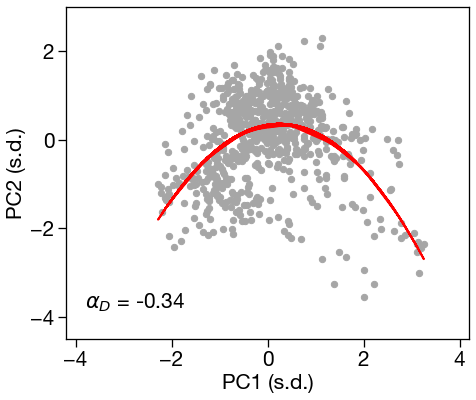

In [15]:
fig = plt.figure(figsize=(7,6))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.1,right=0.9,top=0.9,bottom=0.13,wspace=0.18,hspace=0.4)

ax = plt.subplot(gs2[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)

plt.scatter(pc1,pc2,color=[0.65,0.65,0.65],
           s=40)

predicted = enso_fit[0]*(pc1**2) + enso_fit[1]*pc1 + enso_fit[2]
plt.plot(pc1,predicted,linewidth=2,linestyle="-",color="red")

plt.xlim([-4.2,4.2])
plt.ylim([-4.5,3])                                                     

plt.xlabel("PC1 (s.d.)")
plt.ylabel("PC2 (s.d.)")
plt.text(-3.8,-3.8,r"$\alpha_D$ = "+str(np.around(enso_fit[0],2)))

plt.show()

Calculate final indices

In [16]:
E = (pc1-pc2)/(np.sqrt(2))
C = (pc1+pc2)/(np.sqrt(2))

In [17]:
def monthly_to_yearly_mean(x):

        # calculate annual mean from monthly data
        # after weighting for the difference in month length
        # x must be data-array with time coord
        # xarray must be installed

        # x_yr = x.resample(time="YS").mean(dim="time") is wrong
        # because it doesn't weight for the # of days in each month

        days_in_mon = x.time.dt.days_in_month
        wgts = days_in_mon.groupby("time.year")/days_in_mon.groupby("time.year").sum()
        ones = xr.where(x.isnull(),0.0,1.0)
        x_sum = (x*wgts).resample(time="YS").sum(dim="time")
        ones_out = (ones*wgts).resample(time="YS").sum(dim="time")
        return(x_sum/ones_out)

DJF, where the year is the year of January-February

In [18]:
Eshift = E.shift(time=1)
#E_djf = Eshift[Eshift.time.dt.month<=3].resample(time="YS").mean(dim="time")
Eshift.coords["time"] = pd.date_range(start=str(y1)+"-01-01",end=str(y2)+"-12-31",freq="MS")
E_djf = monthly_to_yearly_mean(Eshift[Eshift.time.dt.month<=3])
Cshift = C.shift(time=1)
#C_djf = Cshift[Cshift.time.dt.month<=3].resample(time="YS").mean(dim="time")
Cshift.coords["time"] = pd.date_range(start=str(y1)+"-01-01",end=str(y2)+"-12-31",freq="MS")
C_djf = monthly_to_yearly_mean(Cshift[Cshift.time.dt.month<=3])

Correlation between DJF and each month

In [19]:
mons = [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,1,2,3,4,5,6,7,8,9,10,11,12]
# (-) means year t, (+) means year t+1
mon_names = ["J","F","M","A","M","J","J","A","S","O","N","D",\
             "J","F","M","A","M","J","J","A","S","O","N","D"]
mon_corrs = np.zeros((2,len(mons)))
mon_pvals = np.zeros((2,len(mons)))
for i in [0,1]:
    if i == 0:
        enso_djf = E_djf
        enso_mon = E
    else:
        enso_djf = C_djf
        enso_mon = C
    for mm in np.arange(0,len(mons),1):
        m = mons[mm]
        if m<0:
            enso_mon_corr = enso_mon[enso_mon.time.dt.month==np.abs(m)].shift(time=1)[1:]
        else:
            enso_mon_corr = enso_mon[enso_mon.time.dt.month==m][1:]
        enso_djf_corr = enso_djf[1:]
            
        mon_corrs[i,mm], mon_pvals[i,mm] = stats.pearsonr(enso_djf_corr,enso_mon_corr)
        #np.corrcoef(enso_djf_corr,enso_mon_corr)[0][1]

Plot E-index and C-index and their DJF-to-monthly correlations

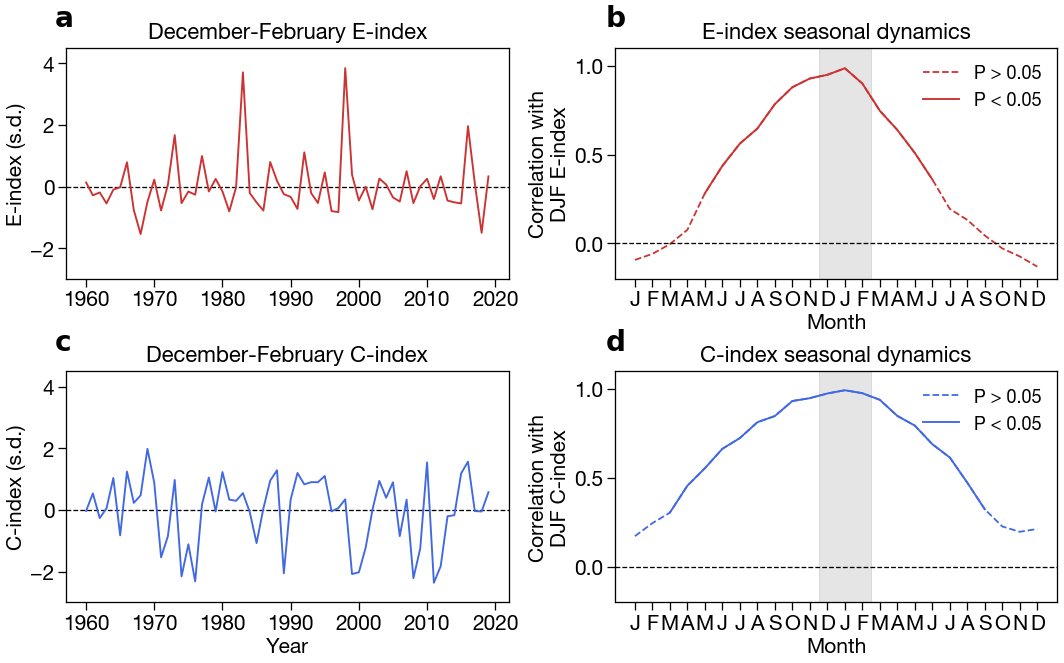

In [20]:
fig = plt.figure(figsize=(17,10))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 21.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.11,right=0.92,top=0.9,bottom=0.13,wspace=0.24,hspace=0.4)

for j in [0,1]:
    
    ax = plt.subplot(gs2[j,0])
    plt.setp(ax.spines.values(), linewidth=1.3)

    if j == 0:
        enso = E_djf
        col = [0.8,0.2,0.2]
    else:
        enso = C_djf
        col = "royalblue"
        
    time = E_djf.time.dt.year.values
    plt.plot(time,enso,linewidth=1.9,color=col,zorder=2)
    
    if j == 0:
        plt.ylabel("E-index (s.d.)")
    else:
        plt.ylabel("C-index (s.d.)")
        plt.xlabel("Year")

    plt.ylim([-3,4.5])
    plt.axhline(y=0,color="black",linewidth=1.3,linestyle="--",zorder=1)
    if j == 0:
        plt.title("December-February E-index",fontsize=22,pad=10)
    else:
        plt.title("December-February C-index",fontsize=22,pad=10)


for j in [0,1]:
    
    ax = plt.subplot(gs2[j,1])
    plt.setp(ax.spines.values(), linewidth=1.3)
    
    corrs = mon_corrs[j,:]
    pvals = mon_pvals[j,:]
    
    if j == 0:
        col = [0.8,0.2,0.2]
    else:
        col = "royalblue"
    
    xvals = np.arange(0,len(corrs),1)
    corrs_sig = corrs[pvals<0.05]
    corrs_nonsig = corrs[pvals>=0.05]
    
    plt.plot(xvals,corrs,linewidth=1.8,color=col,
             linestyle="--",label="P > 0.05")
    plt.plot(xvals[pvals<0.05],corrs_sig,linewidth=1.9,color=col,
             linestyle="-",label="P < 0.05")
    
    
    plt.ylim([-0.2,1.1])
    plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--")
    plt.xticks(ticks=np.arange(0,len(corrs),1),labels=mon_names)
    plt.xlabel("Month")
    
    plt.legend(loc="upper right",frameon=False,fontsize=18)
    
    ax.fill_between([10.5,13.5],-0.2,1.1,color="black",alpha=0.1)
    
    if j == 0:
        plt.title("E-index seasonal dynamics",fontsize=22,pad=10)
        plt.ylabel("Correlation with"+"\n"+"DJF E-index")
    else:
        plt.title("C-index seasonal dynamics",fontsize=22,pad=10)
        plt.ylabel("Correlation with"+"\n"+"DJF C-index")
    
plt.figtext(0.1,0.93,r'$\bf{a}$',fontsize=28)
plt.figtext(0.55,0.93,r'$\bf{b}$',fontsize=28)
plt.figtext(0.1,0.48,r'$\bf{c}$',fontsize=28)
plt.figtext(0.55,0.48,r'$\bf{d}$',fontsize=28)

plt.savefig("../Figures/FigX_E_C_Timeseries.pdf")
plt.show()

Calculate nino3 and nino3.4

In [21]:
lat_min_nino3 = -5
lat_max_nino3 = 5
lon_min_nino3 = 210
lon_max_nino3 = 270

lat_min_nino34 = -5
lat_max_nino34 = 5
lon_min_nino34 = 190
lon_max_nino34 = 240

In [22]:
nino3 = sst_detrended.load().loc[:,lat_min_nino3:lat_max_nino3,lon_min_nino3:lon_max_nino3].mean(dim=["lat","lon"])
nino34 = sst_detrended.load().loc[:,lat_min_nino34:lat_max_nino34,lon_min_nino34:lon_max_nino34].mean(dim=["lat","lon"])

In [24]:
C_djf.loc["1984-01-01"].values

array(-0.0700892)

In [25]:
C_djf.loc["1985-01-01"].values

array(-1.07768107)

In [26]:
C_djf.loc["1999-01-01"].values

array(-2.08300837)

In [27]:
C_djf.loc["2000-01-01"].values

array(-2.02639621)

Write out

In [28]:
enso_ds = xr.Dataset({"e_index":(["time"],E),
                     "c_index":(["time"],C),
                     "nino3":(["time"],nino3),
                     "nino34":(["time"],nino34)},
                    coords={"time":(["time"],E.time.values)})

enso_ds.attrs["creation_date"] = str(datetime.datetime.now())
enso_ds.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
enso_ds.attrs["variable_description"] = "monthly e_index, c_index, and nino3/nino3.4 anomalies from obs SST"
enso_ds.attrs["created_from"] = os.getcwd()+"/Observed_ENSO_Indices.ipynb"

fname_out = loc_out+"obs_ENSO_indices_monthly_"+str(y1)+"-"+str(y2)+".nc"
enso_ds.to_netcdf(fname_out,mode="w")
print(fname_out)

../Data/ENSO_Indices/obs_ENSO_indices_monthly_1960-2019.nc
